In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [667]:
paths = {
    'agro': 'data/agro/agro.csv',
    'syn': list(Path('data/syn').rglob('*.csv'))
}


In [668]:
agro = pd.read_csv(paths['agro'])


In [669]:
agro.kult.nunique()

177

In [413]:
agro = pd.read_csv(paths['agro'])
syn = pd.read_csv(paths['syn'][1], usecols=['s_ind', 'datetime', 't2m', 'td2m', 'ff', 'R12'])
syn.loc[syn.datetime.astype(str).str.len() == 7, 'datetime'] = '0'+\
    syn[syn.datetime.astype(str).str.len() == 7].datetime.astype(str)
syn.loc[:, 'datetime'] = pd.to_datetime(syn.datetime, format='%y%m%d%H')

Обработывать уже сами временные промежутки. То есть сначала объединить таблицы, а потом обрабатывать данные

In [415]:
agro.loc[:,'datetime'] = pd.to_datetime(agro.year.astype(str)+agro.month.astype(str) + agro.day.astype(str)+np.ones(len(agro), dtype='str'), format='%Y%m%d%H', origin='unix')
agro = agro.drop(['month', 'day'], axis=1)
agro.loc[:,'prev'] = agro.dec - 1

In [416]:
df = agro.merge(agro, left_on=['ind', 'dec', 'year'], right_on=['ind', 'prev', 'year'], suffixes=('', '_next'))
df.loc[:, 'dur'] = (df.datetime_next - df.datetime).dt.days.astype(int)
df.loc[df.dur == 11, 'datetime_next'] = df[df.dur == 11].datetime_next-pd.Timedelta('1d')
df.loc[:, 'dur'] = (df.datetime_next - df.datetime).dt.total_seconds().astype(int)


In [418]:
new_agro = pd.to_datetime((np.repeat(df.datetime.view(int)//int(1e9), 240) + np.hstack(
    [np.arange(0, v, pd.Timedelta('1h').total_seconds()) for v in df.dur]))*int(1e9))
new_agro = df.join(new_agro.rename('ts'), how='outer')


In [419]:
pairs = pd.read_csv('data/pairs/pairs.csv')

In [421]:
syn = syn.merge(pairs[pairs.dist < 20], on='s_ind')

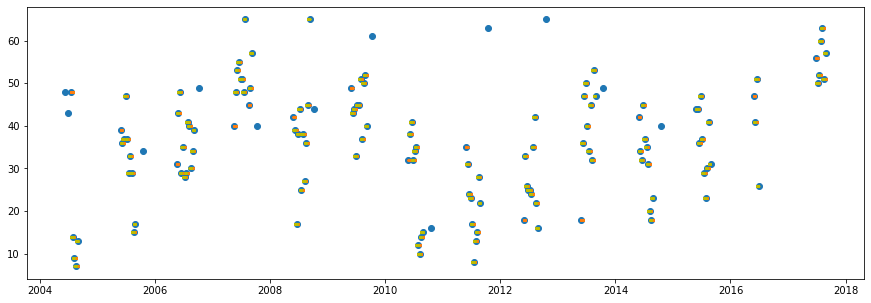

In [422]:
plt.figure(figsize=(15,5))
plt.scatter(agro[agro.ind == 22559].datetime, agro[agro.ind == 22559].val_2)
plt.scatter(new_agro[new_agro.ind == 22559].ts, new_agro[new_agro.ind == 22559].val_2, s=1)
plt.scatter(new_agro[new_agro.ind == 22559].ts, new_agro[new_agro.ind == 22559].val_2_next, s=1, c='y')
plt.show()


In [468]:
data = new_agro.merge(syn, left_on=['ind', 'ts'], right_on=['ind','datetime'], how='inner')
agr = data.groupby(['ind', 'year', 'dec']).val_1.count()
data = data.set_index(['ind', 'year', 'dec']).loc[agr[agr == 80].index].reset_index()
data.loc[:, ['t2m', 'td2m', 'ff']] = data[['t2m', 'td2m', 'ff']].interpolate(method='polynomial', order=3)


In [469]:
for i,j in data[['s_ind','dec']].drop_duplicates().values:
    data.loc[(data.s_ind == i) & (data.dec == j), 'R12'] = (data[(data.s_ind == i) & (data.dec == j)].R12/4).fillna(method='bfill', limit=3).fillna(0)

+ климат (по s_ind)
+ почвы и поверхности (по ind)
+ попробовать разложжение матриц для эмбеддингов (факторизовать)

In [435]:
import netCDF4
from sklearn.metrics import pairwise_distances
from src.tools.settings import CLIMATE_OPT

In [696]:
netCDF4.Dataset(list(CLIMATE_OPT.keys())[2])[list(CLIMATE_OPT.values())[2]]


<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    long_name: Average Long Term Monthly Rate of Precipitation
    valid_range: [  0. 150.]
    units: mm/day
    missing_value: -9.96921e+36
    Fill_Value: -9.96921e+36
    precision: 2
    least_significant_digit: 2
    var_desc: Precipitation
    dataset: Precipitation Reconstruction over Land (PREC/L):0.5x0.5
    level_desc: Surface
    statistic: Long Term Mean
    parent_stat: Mean
    actual_range: [ 0.       59.510403]
unlimited dimensions: 
current shape = (12, 360, 720)
filling on, default _FillValue of 9.969209968386869e+36 used

In [445]:
nc = netCDF4.Dataset('data/climate/air.mon.1981-2010.ltm.nc')
latmask = np.argmin(pairwise_distances(nc['lat'][:].data.reshape(-1, 1),
                                       pairs['s_lat'].values.reshape(-1, 1)), axis=0)
lonmask = np.argmin(pairwise_distances(nc['lon'][:].data.reshape(-1, 1),
                                       pairs['s_lon'].values.reshape(-1, 1)), axis=0)

climate = pd.DataFrame()

for i in range(12):
    df = pairs[['s_ind']].copy()
    for path in CLIMATE_OPT.keys():
        nc = netCDF4.Dataset(path)
        df.loc[:, 'month'] = i+1
        df.loc[:, CLIMATE_OPT[path]] = nc[CLIMATE_OPT[path]][i].data[latmask, lonmask]
    climate = pd.concat((climate, df), axis=0, ignore_index=True)

In [453]:
from geotiff import GeoTiff

In [454]:
lat, lon = pairs.loc[:, 'lat'].to_numpy().astype(int), pairs.loc[:, 'lon'].to_numpy().astype(int)

In [455]:
def decode_tif(lat, lon, tifname):

    lon1 = lon.min()
    lon2 = lon.max()
    lat1 = lat.min()
    lat2 = lat.max()
    arr = np.array(GeoTiff(tifname).read_box([(lon1, lat1), (lon2, lat2)]))
    ilon = np.round((lon-lon1)/(lon2-lon1)*(arr.shape[1]-1)).round().astype(np.int64)
    ilat = np.round((lat2-lat)/(lat2-lat1)*(arr.shape[0]-1)).round().astype(np.int64)
    out = np.array([arr[ilat[i], ilon[i]] for i in range(ilon.shape[0])])

    return out

In [456]:
tifname = 'data/agro/soil/so2015v2.tif'
pairs.loc[:, 'soiltype'] = decode_tif(lat, lon, tifname)
tifname = 'data/agro/cover/GLOBCOVER_L4_200901_200912_V2.3.tif'
pairs.loc[:, 'covertype'] = decode_tif(lat, lon, tifname)

In [457]:
pairs

,ind,lat,lon,s_ind,dist,s_lat,s_lon,soiltype,covertype
0,22559,64.216,41.666000,22559,0.1,64.217,41.667,81,50
1,22656,63.483,41.800000,22656,0.0,63.483,41.800,81,90
2,22768,62.100,42.900000,22768,0.0,62.100,42.900,81,100
3,22798,62.167,49.117000,22798,0.0,62.167,49.117,19,100
4,22802,61.716,30.716000,22802,0.1,61.717,30.717,0,210
...,...,...,...,...,...,...,...,...,...
748,66001,56.350,55.316667,28419,27.3,56.267,54.900,81,14
749,66003,58.100,55.550000,28321,43.7,57.717,55.383,81,100
750,66004,56.950,56.816667,28429,57.0,56.483,57.200,98,20
751,66005,56.916,55.600000,28324,41.8,57.283,55.450,81,14


In [459]:
cover_df = pd.read_excel('/Users/haru4me/Documents/NeuralODE_v2/data/agro/cover/Globcover2009_Legend.xls', usecols=['Value', 'Label'])
soil_df = pd.read_csv('data/agro/soil/2015_suborders_and_gridcode.txt', sep='\t')

In [460]:
soils = pairs.merge(cover_df, left_on='covertype', right_on='Value')\
               .merge(soil_df, left_on='soiltype', right_on='GRIDCODE')\
               .drop(['Value', 'GRIDCODE', 'lat', 'lon', 's_ind', 'dist', 's_lat', 's_lon'], axis=1)\
               .rename(columns={'Label': 'cover_name', 'SOIL_ORDER': 'soil_label', 'SUBORDER': 'suborder'})\
               .astype({'covertype':'int64'})

soils.loc[:, 'covertype'] = soils.covertype.map(
    {elm: i for i, elm in enumerate(soils.covertype.sort_values().unique())}).astype(int)

soils.loc[:, 'soiltype'] = soils.soiltype.map(
    {elm: i for i, elm in enumerate(soils.soiltype.sort_values().unique())}).astype(int)

soils_label = pd.DataFrame()
soils_label.loc[:, 'soiltypes'] = {i: elm for i, elm in  enumerate(soils.soil_label.unique())}.keys()
soils_label.loc[:, 'soil_label'] = {i: elm for i, elm in  enumerate(soils.soil_label.unique())}.values()

soils = soils.merge(soils_label, on='soil_label')\
                .drop('soiltype', axis=1)\
                .rename(columns={'soiltypes': 'soiltype'})

In [463]:
climate.drop_duplicates().reset_index()

,index,s_ind,month,air,soilw,precip
0,0,22559,1,259.492004,291.252075,1.105733
1,1,22656,1,259.545349,291.290802,1.105233
2,2,22768,1,260.131653,317.480499,1.156833
3,3,22798,1,258.259674,319.963806,1.321633
4,4,22802,1,265.048309,379.280273,1.439100
...,...,...,...,...,...,...
7987,9011,28886,12,259.660004,156.913162,0.718033
7988,9030,29866,12,257.771362,208.346024,0.492833
7989,9033,28429,12,261.055695,287.277466,1.106967
7990,9034,28324,12,261.823975,300.975067,1.272800


In [462]:
soils.drop_duplicates()

,ind,covertype,cover_name,soil_label,suborder,soiltype
0,22559,4,Closed (>40%) broadleaved deciduous forest (>5m),Alfisols,Cryalfs,0
1,22912,4,Closed (>40%) broadleaved deciduous forest (>5m),Alfisols,Cryalfs,0
2,22954,4,Closed (>40%) broadleaved deciduous forest (>5m),Alfisols,Cryalfs,0
3,22974,4,Closed (>40%) broadleaved deciduous forest (>5m),Alfisols,Cryalfs,0
4,23914,4,Closed (>40%) broadleaved deciduous forest (>5m),Alfisols,Cryalfs,0
...,...,...,...,...,...,...
748,29708,2,Mosaic cropland (50-70%) / vegetation (grassla...,Aridisols,Argids,11
749,29827,2,Mosaic cropland (50-70%) / vegetation (grassla...,Aridisols,Argids,11
750,36639,14,Bare areas,Aridisols,Argids,11
751,30978,3,Mosaic vegetation (grassland/shrubland/forest)...,Aridisols,Cryids,11


In [472]:
data = data.merge(soils, on='ind').merge(climate, left_on=['s_ind', data.ts.dt.month], right_on=['s_ind','month'])

In [703]:
data.loc[:, 'phi'] = np.sin(((data.ts-pd.Timestamp('1970-01-01'))/pd.Timedelta(seconds=1)/pd.Timedelta(days=365.24).total_seconds()*2*np.pi))
data.loc[:, 'air'] = data.air-272.1

In [699]:
data.R12.mean()*4

12.100544794188862

In [701]:
(data.air-272.1).mean()

20.132744

In [702]:
data.t2m.mean()

19.662074549883098

In [704]:
data[['ind', 'dec', 'dec_next', 'ts', 'phi', 't2m', 'td2m', 'ff', 'R12', 'kult', 'soiltype', 'covertype', 'air', 'soilw', 'precip',
      'val_1', 'val_2', 'val_1_next', 'val_2_next']]


,ind,dec,dec_next,ts,phi,t2m,td2m,ff,R12,kult,soiltype,covertype,air,soilw,precip,val_1,val_2,val_1_next,val_2_next
0,22559,19,20,2007-07-07 03:00:00,-0.079479,18.8,18.1,2.0,10.0,77,0,4,17.546661,240.907227,2.009567,26.0,51.0,23.0,48.0
1,22559,19,20,2007-07-07 06:00:00,-0.081623,21.8,19.5,2.0,10.0,77,0,4,17.546661,240.907227,2.009567,26.0,51.0,23.0,48.0
2,22559,19,20,2007-07-07 09:00:00,-0.083766,26.1,20.3,3.0,10.0,77,0,4,17.546661,240.907227,2.009567,26.0,51.0,23.0,48.0
3,22559,19,20,2007-07-07 12:00:00,-0.085908,24.0,20.2,2.0,10.0,77,0,4,17.546661,240.907227,2.009567,26.0,51.0,23.0,48.0
4,22559,19,20,2007-07-07 15:00:00,-0.088051,24.8,22.0,1.0,10.0,77,0,4,17.546661,240.907227,2.009567,26.0,51.0,23.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33035,59606,20,21,2007-07-26 12:00:00,-0.401239,34.1,13.6,5.0,0.0,465,6,2,24.210388,248.589523,2.085233,0.0,2.0,0.0,1.0
33036,59606,20,21,2007-07-26 15:00:00,-0.403208,32.5,13.4,6.0,0.0,465,6,2,24.210388,248.589523,2.085233,0.0,2.0,0.0,1.0
33037,59606,20,21,2007-07-26 18:00:00,-0.405175,27.3,12.1,5.0,0.0,465,6,2,24.210388,248.589523,2.085233,0.0,2.0,0.0,1.0
33038,59606,20,21,2007-07-26 21:00:00,-0.407140,24.6,7.3,3.0,0.0,465,6,2,24.210388,248.589523,2.085233,0.0,2.0,0.0,1.0


In [ ]:
# back training stats

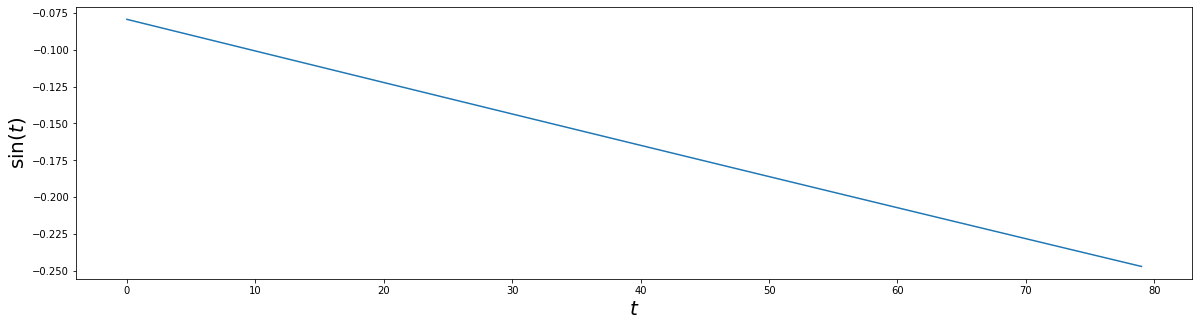

In [678]:
t = (data[data.ind == data.ind.unique()[0]].ts.reset_index(drop=True)-pd.Timestamp('1970-01-01'))/pd.Timedelta(seconds=1)
phi = np.sin(t/pd.Timedelta(days=365.24).total_seconds()*2*np.pi)
plt.figure(figsize=(20,5))
plt.plot(phi)
plt.xlabel('$t$', size=20)
plt.ylabel('$\sin(t)$', size=20)
plt.show()